# Training Variational Quantum Models with Barren Plateaus Mitigation Strategies
*Training QNN treated with method 0 (General) of the BP mitigation strategy (Cancer)*

**Authors:**
- Jacob Cybulski and Thanh Nguyen


In [1]:
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import torch
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import *
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.utils import *

from IPython.display import clear_output

In [2]:
from os.path import exists
from os import makedirs

In [3]:
# Global config for all experiments (data size, feature dim etc.) is stored here
from GLOBAL_CONFIG import *
# Remember to tag the method
METHOD_TAG = 'm0'

In [4]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [5]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [6]:
if (exists(f'{LOG_PATH}/{METHOD_TAG}')):
    print(f'Found save folder: {LOG_PATH}/{METHOD_TAG}\n')
else:
    makedirs(f'{LOG_PATH}/{METHOD_TAG}')
    print(f'Creating save folder: {LOG_PATH}/{METHOD_TAG}\n')

Found save folder: ./Logs-Cancer-v4/m0



## Measuring Gradient Variance Decay

In [7]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [8]:
reps = num_qubits
ansatzes_m0 = [AnsatzGenerator(n, r) for n, r in zip(num_qubits, reps)]

In [9]:
def sampleM0Var():
    gradients_m0 = sampleAnsatz(estimator, ansatzes_m0, G_O)
    variance = getVariance(gradients_m0, num_qubits)
    return variance

## Loss Function Surface

In [10]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)
initial_point = np.random.uniform(0, np.pi/2, ansatz.num_parameters)

In [11]:
### Find what devices are available
from qiskit_aer.backends import AerSimulator
devices = AerSimulator().available_devices()
devices

# Force CPU - PyTorch+Qiskit too slow with GPU
devices = ('CPU')
devices

'CPU'

In [12]:
from qiskit.primitives import Estimator # For "CPU", ignores device="GPU" option
from qiskit_aer.primitives import Estimator as AerEstimator # For device="GPU" option

seed = 2023

# Use GPU when present, otherwise CPU
if 'GPU' in devices:
    device = 'GPU'
    estimator = AerEstimator(
        backend_options={'seed_simulator': seed, 'method': 'statevector', 
                         'device' : device, 'cuStateVec_enable' : True},
        run_options={'seed': seed, 'shots': 1000},
        transpile_options={"seed_transpiler": seed},
    )
else:
    device = 'CPU'
    estimator = Estimator()
    estimator.set_options(method='statevector')
    estimator.set_options(device=device)
    estimator.set_options(seed=seed)
    estimator.options

print(f'Selected device: {device}')

Selected device: CPU


In [13]:
res = pd.DataFrame()
epochs = 200

start = time.time()
for i in range(0, epochs):
    print('iteration: ', i)
    display(res)
    pertubated_initial_point = initial_point + np.random.uniform(-0.1, 0.1, ansatz.num_parameters)
    
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    model = TorchConnector(qnn, initial_weights=pertubated_initial_point)

    loss_function = nn.L1Loss() #This is MAE loss
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    loss, weight = sampleWeightLoss(
        model, 
        X_train_t,
        y_train_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    res = pd.concat([res, pd.DataFrame(np.append(weight.numpy(), loss.numpy())).transpose()], ignore_index=True) 
    clear_output(wait=True)
elapsed = time.time() - start

pd.DataFrame(res).astype('float').to_csv(f'{LOG_PATH}/{METHOD_TAG}/LossFunctionSurface.csv')

iteration:  199


,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,0.840491,0.566213,0.183908,0.546574,0.825985,1.270381,1.207503,1.345008,1.401224,0.347463,...,0.861419,0.294422,1.481696,0.896405,0.004745,1.536161,0.967073,0.480881,0.660062,1.020032
1,0.853754,0.570294,0.192387,0.497171,0.850759,1.247002,1.237285,1.238470,1.234491,0.465397,...,0.741976,0.172158,1.619292,0.859829,0.051034,1.490036,0.922520,0.399141,0.722040,1.012344
2,0.681476,0.550527,0.125146,0.534478,0.852737,1.269381,1.210432,1.363982,1.285829,0.368715,...,0.747362,0.249047,1.491417,0.906802,-0.000528,1.490138,1.005807,0.540226,0.576980,1.018479
3,0.738816,0.606690,0.146751,0.500567,0.816395,1.370196,1.198878,1.237656,1.411344,0.460573,...,0.749211,0.349778,1.526138,0.768802,0.058630,1.438559,0.992545,0.469535,0.645247,1.020990
4,0.668129,0.480012,0.263029,0.453757,0.768117,1.367363,1.233311,1.397921,1.245559,0.424810,...,0.764575,0.254160,1.606197,0.794197,0.078482,1.437793,0.868852,0.511099,0.622348,1.011263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.807904,0.436785,0.317192,0.444462,0.738018,1.235297,1.196052,1.298125,1.368381,0.362318,...,0.738334,0.268038,1.540466,0.722260,0.109215,1.549334,0.910625,0.423968,0.577182,1.022982
195,0.811306,0.584549,0.135549,0.435725,0.673163,1.257014,1.185955,1.256274,1.343091,0.301244,...,0.769914,0.306757,1.486325,0.786320,-0.023384,1.428756,0.997197,0.430432,0.582699,1.027691
196,0.752170,0.516660,0.168693,0.494721,0.803033,1.205740,1.299089,1.358758,1.321439,0.292450,...,0.768495,0.316887,1.518312,0.828099,0.047222,1.546371,0.844334,0.436927,0.581821,1.015679
197,0.850962,0.572957,0.146341,0.469421,0.739136,1.358182,1.266770,1.204331,1.254504,0.285733,...,0.751274,0.275304,1.536414,0.896049,0.063876,1.552366,0.834046,0.420284,0.665581,1.028361


In [14]:
# Print run statistics
print(f'{device} Fit\n'+
      f'\tQubits:\t\t{num_qubits}\n'+
      f'\tReps:\t\t{reps}\n'+
      f'\tWeights:\t{len(ansatz.parameters)}\n'+
      f'\tEpochs:\t\t{epochs})\n'+
      f'\tTime:\t\t{elapsed:0.2f} sec')

CPU Fit
	Qubits:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Reps:		[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
	Weights:	104
	Epochs:		200)
	Time:		586.60 sec


## Measure Training Performance

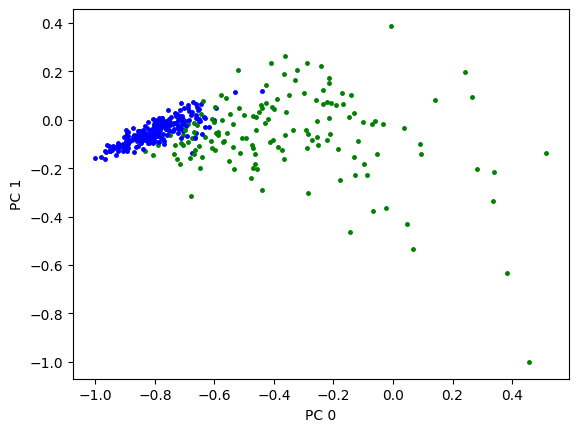

Blue: torch.Size([250])
Green: torch.Size([148])


In [15]:
# Plot dataset (only the first two args)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[1], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[1], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

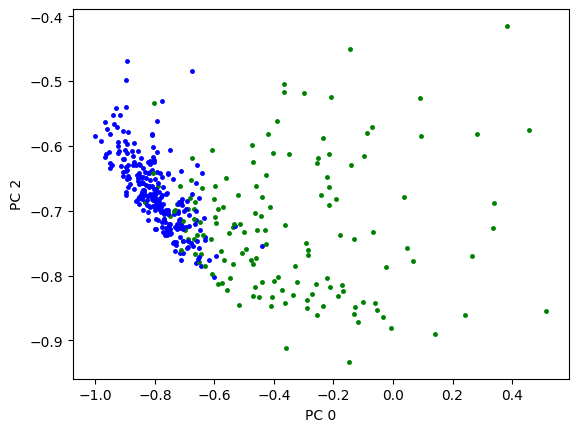

Blue: torch.Size([250])
Green: torch.Size([148])


In [16]:
# Plot dataset (only the first and the third arg)
for x, y_target in zip(X_train_t, y_train_t):
    if y_target == 1:
        plt.plot(x[0], x[2], color="blue", marker=".", markersize=5)
    else:
        plt.plot(x[0], x[2], color="green", marker=".", markersize=5)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
plt.show()

rows_b = np.where(np.array(y_train_t)==1)
rows_g = np.where(np.array(y_train_t)==-1)
print('Blue:', y_train_t[rows_b].size())
print('Green:', y_train_t[rows_g].size())

In [17]:
feature_map = featureMapGenerator(FEATURE_DIM)
ansatz = AnsatzGenerator(MAX_QUBITS_CLASSIFICATION, MAX_REPS, ENTANGLEMENT)
qc = circuitBuilder(feature_map, ansatz)

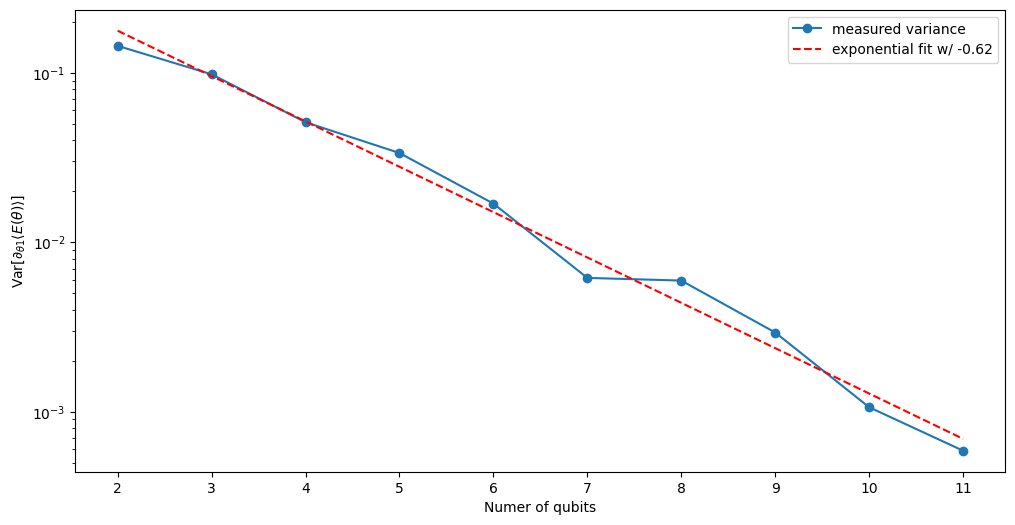

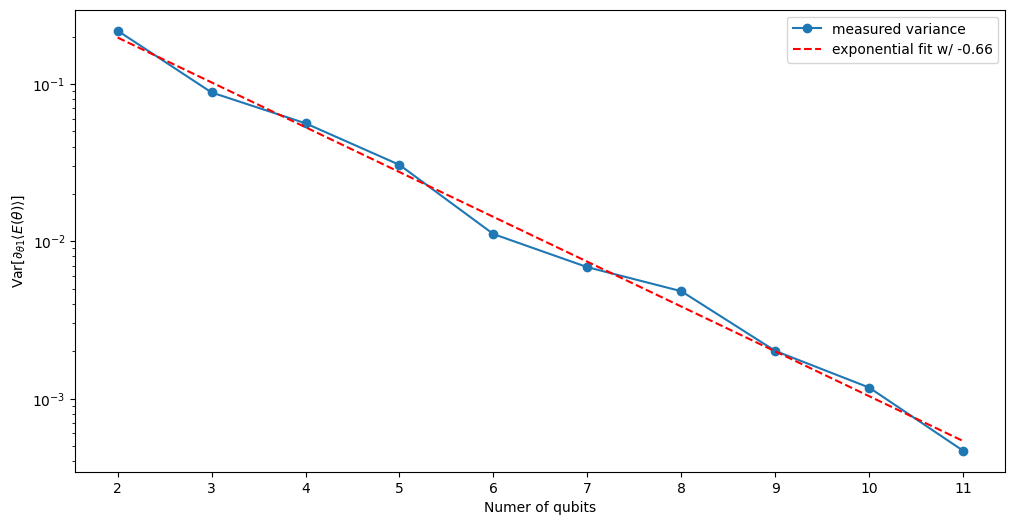

In [18]:
# To execute on multiple machines concurrently
# Select separate sub-lists of instance numbers and run
# Alternatively use range(MAX_INST) for all

m = METHOD_TAG
path = LOG_PATH
times = []

# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 
for i in [2, 3]: 
     
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}')):
        print(f'Adding a new instance {i} of method {m}\n')
    else:
        makedirs(f'{path}/{m}')
        print(f'Creating the first instance {i} of method {m}\n')

    m0_variances = sampleM0Var()
        
    # By default this will run as a local simulation
    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        observables=GLOBAL_OPERATOR,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters
    )

    # By default random initialisation
    model = TorchConnector(qnn)

    loss_function = nn.L1Loss() # nn.MSELoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

    start = time.time()
    model, losses, accuracy_train, accuracy_test, weights = train(
        model, 
        MAX_ITER, 
        X_train_t,
        y_train_t,
        X_val_t,
        y_val_t,
        optimizer = optimizer, 
        loss_function = loss_function
        )
    elapsed = time.time() - start
    times.append(elapsed)

    pd.DataFrame(m0_variances, num_qubits).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Variances.csv')
    pd.DataFrame(losses).astype('float').to_csv(f'{path}/{m}/{m}-{i}-LossFunction.csv')
    pd.DataFrame(accuracy_train).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Train.csv')
    pd.DataFrame(accuracy_test).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Scores-Test.csv')
    pd.DataFrame(weights).astype('float').to_csv(f'{path}/{m}/{m}-{i}-Weights.csv')
    
    # Mark that the method's data has been saved
    if (exists(f'{path}/{m}/{m}-Method.csv')):
        f = open(f'{path}/{m}/{m}-Method.csv', 'a')
    else:
        f = open(f'{path}/{m}/{m}-Method.csv', 'w')
        f.write(f'{m},Instance,Max Inst,Examples,Features,Iterations\n')
    f.write(f',{i},{MAX_INST},{DATA_SIZE},{FEATURE_DIM},{MAX_ITER}\n')
    f.close()
    
    clear_output(wait=True)


In [19]:
print(f'\nAverage time / instance: {np.average(times)}')


Average time / instance: 38977.91289663315


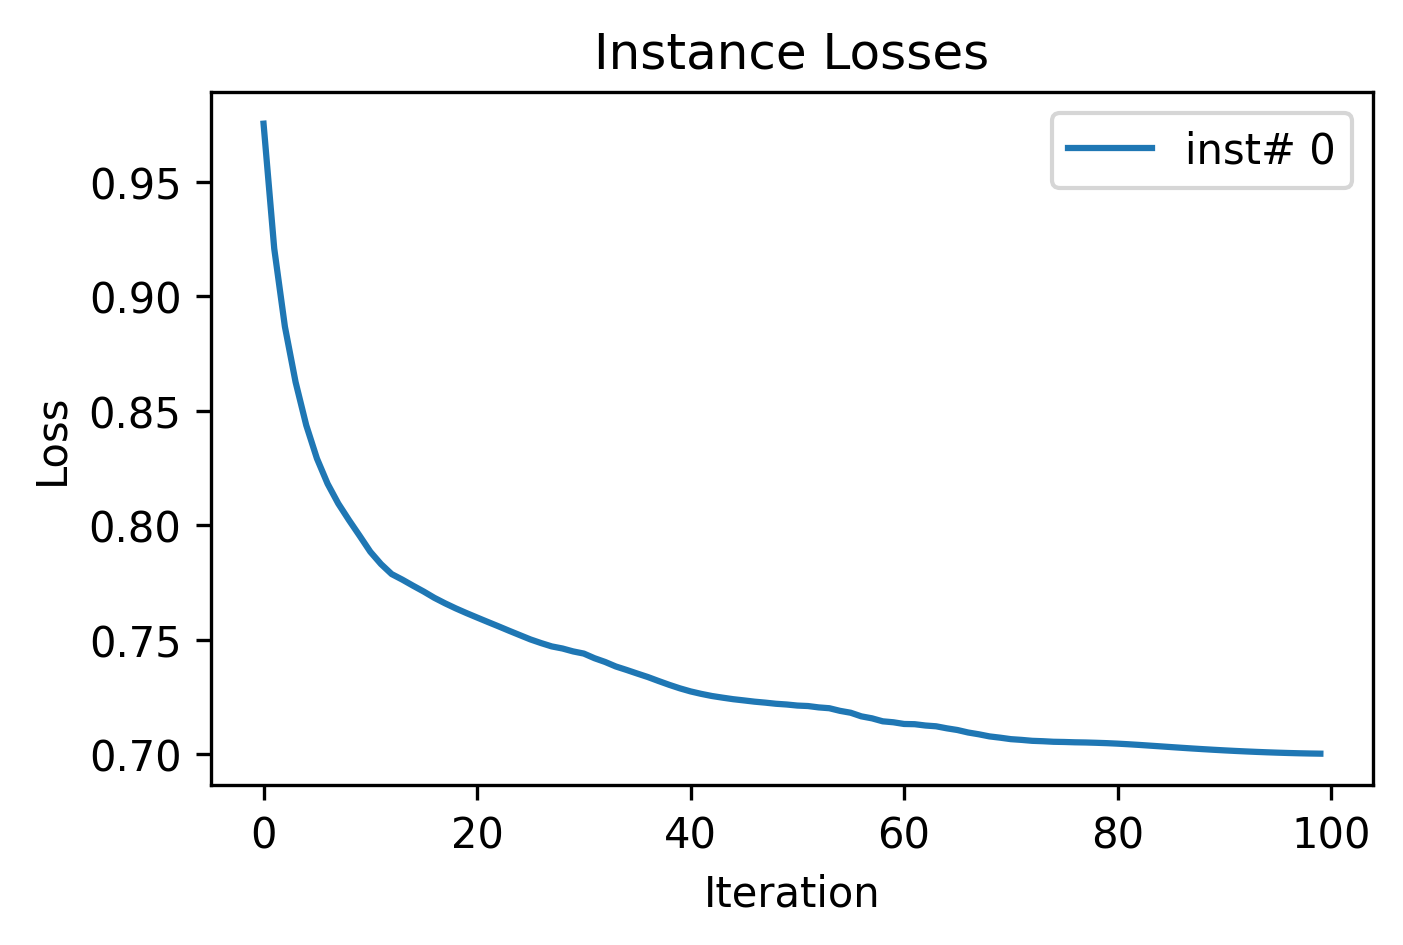

In [20]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(losses).astype('float').T])

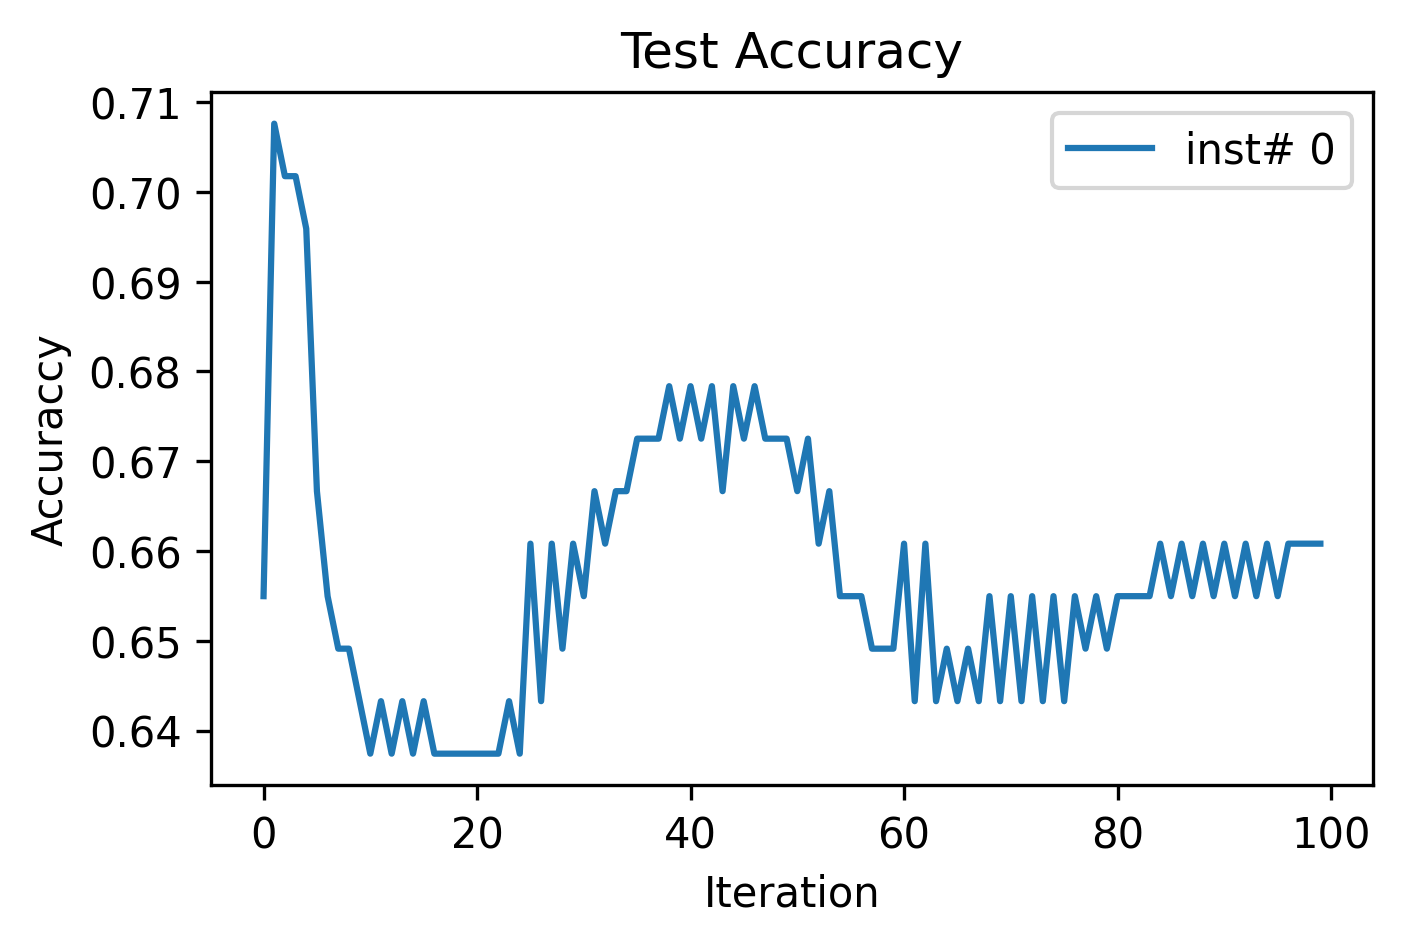

In [21]:
# Plot the loss of the last saved instance
plot_method_data([pd.DataFrame(accuracy_test).astype('float').T],
                title='Test Accuracy', dlabel='inst#', xlabel='Accuraccy', ylabel='Iteration')

In [22]:
!pip list | grep qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2


In [23]:
!pip list | grep torch

torch                         2.1.0
torchaudio                    2.1.0
torchsummary                  1.5.1
torchvision                   0.16.0
